#Import

In [3]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")

import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Aug 11 23:25 kaggle.json


In [6]:
os.chdir('/content/drive/MyDrive/DS/identification/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2')

In [7]:
def load_alice_data():
    return pd.read_csv('train_sessions.csv', index_col='session_id', parse_dates=['time1']), \
            pd.read_csv('test_sessions.csv', index_col='session_id', parse_dates=['time1'])

df_train, df_test = load_alice_data()
df_train = df_train.sort_values(by="time1")

for i in range(2, 11):
    df_train['time{}'.format(i)] = pd.to_datetime(df_train['time{}'.format(i)])
for i in range(2, 11):
    df_test['time{}'.format(i)] = pd.to_datetime(df_test['time{}'.format(i)])

In [ ]:
df_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,945.0,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,946.0,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,952.0,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


# EDA

## Топ-сайты

Посмотрим на самые посещаемые сайты Алисой

In [ ]:
#Функция для определения самых популярных сайтов, куда заходила Алиса
def top_sites(data, top=10):
  sites = np.array(df_train[list(filter(lambda x: 'site' in x, df_train.columns))])
  sites_alice = np.array(data[list(filter(lambda x: 'site' in x, data.columns))])[data.target == 1].ravel()
  sites_alice = sites_alice[~np.isnan(sites_alice)].astype(int)

  unique = np.unique(sites_alice, return_counts=True)[0]
  freq = np.unique(sites_alice, return_counts=True)[1]
  mask_a = np.argpartition(-freq, top)[:top]
  top_alice = unique[mask_a]

  df_alice = sites[data.target == 1]
  is_top_alice = np.zeros(df_alice.shape[0])

  for row in range(df_alice.shape[0]):
    is_top_alice[row] = np.any(np.isin(df_alice[row], top_alice))

  return is_top_alice

In [ ]:
sites = np.array(df_train[list(filter(lambda x: 'site' in x, df_train.columns))])

sites_rest = np.array(df_train[list(filter(lambda x: 'site' in x, df_train.columns))])[df_train.target == 0].ravel()
sites_alice = np.array(df_train[list(filter(lambda x: 'site' in x, df_train.columns))])[df_train.target == 1].ravel()

sites_alice = sites_alice[~np.isnan(sites_alice)].astype(int)
sites_rest = sites_rest[~np.isnan(sites_rest)].astype(int)

unique = np.unique(sites_alice, return_counts=True)[0]
freq = np.unique(sites_alice, return_counts=True)[1]
mask_a = np.argpartition(-freq, 30)[:30]
top_alice = unique[mask_a]

In [ ]:
#id-номера сайтов
top_alice

array([   21,    75,    76,    77,    80,    81,    29,    22,   879,
          82,    23,  3000,   733,    37,    35,    33,   881,    30,
        2078,  7832,   941,   704,    52,    78,   617,   942,   270,
        1057,   335, 12619])

In [ ]:
df_rest = sites[df_train.target == 0]
is_top_alice = np.zeros(df_rest.shape[0])
for row in range(df_rest.shape[0]):
  is_top_alice[row] = np.any(np.isin(df_rest[row], top_alice))
np.unique(is_top_alice, return_counts=True)

(array([0., 1.]), array([127546, 123718]))

In [ ]:
df_alice = sites[df_train.target == 1]
is_top_alice = np.zeros(df_alice.shape[0])
for row in range(df_alice.shape[0]):
  is_top_alice[row] = np.any(np.isin(df_alice[row], top_alice))
np.unique(is_top_alice, return_counts=True)

(array([0., 1.]), array([1159, 1138]))

In [ ]:
is_top_alice = np.zeros(sites.shape[0])
for row in range(sites.shape[0]):
  is_top_alice[row] = np.any(np.isin(sites[row], top_alice))
np.unique(is_top_alice, return_counts=True)

(array([0., 1.]), array([128134, 125427]))

теперь с помощью словаря узнаем, что это за сайты

In [ ]:
path_pkl = '/content/drive/MyDrive/DS/identification/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl'

In [ ]:
with open(path_pkl, 'rb') as f:
  sites_dict = pickle.load(f)

In [ ]:
values = np.array(list(sites_dict.values()))
items = list(sites_dict.items())
alice_popular = []
for i in range(top_alice.shape[0]):
  index = int(np.argwhere(values == top_alice[i]))
  site = items[index][0]
  alice_popular.append(site)

In [ ]:
df_alice = sites[df_train.target == 1]
site_counter = np.zeros(top_alice.shape[0])
for i in range(top_alice.shape[0]):
  is_site = np.zeros(df_alice.shape[0])
  for row in range(df_alice.shape[0]):
    is_site[row] = np.any(np.isin(df_alice[row], top_alice[i]))
  site_counter[i] = np.sum(is_site)

In [ ]:
df_rest = sites[df_train.target == 0]
site_counter_rest = np.zeros(top_alice.shape[0])
for i in range(top_alice.shape[0]):
  is_site = np.zeros(df_rest.shape[0])
  for row in range(df_rest.shape[0]):
    is_site[row] = np.any(np.isin(df_rest[row], top_alice[i]))
  site_counter_rest[i] = np.sum(is_site)

In [ ]:
shares_of_pop = pd.DataFrame({'alice': site_counter / df_alice.shape[0],
              'rest': site_counter_rest / df_rest.shape[0]})
shares_of_pop['diff'] = shares_of_pop['alice'] - shares_of_pop['rest']
shares_of_pop['abs_diff'] = shares_of_pop['diff'].abs()
shares_of_pop['site'] = alice_popular

In [ ]:
#разница в частоте встречаемости сайтов у Алисы и всех остальных
shares_of_pop

,alice,rest,diff,abs_diff,site
0,0.158468,0.255807,-0.097339,0.097339,www.google.fr
1,0.131040,0.024946,0.106095,0.106095,s.ytimg.com
2,0.307357,0.046322,0.261036,0.261036,www.youtube.com
3,0.290379,0.037188,0.253191,0.253191,i1.ytimg.com
4,0.281672,0.041693,0.239979,0.239979,s.youtube.com
5,0.103613,0.009424,0.094189,0.094189,r4---sn-gxo5uxg-jqbe.googlevideo.com
6,0.249020,0.154280,0.094741,0.094741,www.facebook.com
7,0.180670,0.171159,0.009512,0.009512,apis.google.com
8,0.089682,0.010133,0.079549,0.079549,r1---sn-gxo5uxg-jqbe.googlevideo.com
9,0.084023,0.009874,0.074149,0.074149,r2---sn-gxo5uxg-jqbe.googlevideo.com


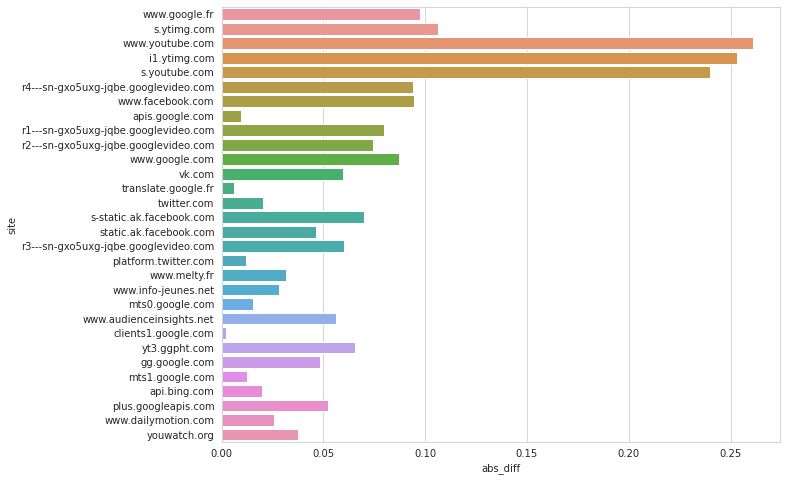

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x=shares_of_pop['abs_diff'], y=shares_of_pop['site'])

Похоже, что Алиса любит посещать видеохостинги. Посмотрим на её посещаемость подобных сайтов более подробно.

In [ ]:
youtube = list(filter(lambda x: 'youtube' in x[0], items))
youtube

In [ ]:
def sites_difference(sites, string):
  target_sites = list(filter(lambda x: string in x[0], items))
  sites_indexes = np.array([i[1] for i in target_sites])
  sites_names = [i[0] for i in target_sites]


  df_alice = sites[df_train.target == 1]
  site_counter = np.zeros(sites_indexes.shape[0])
  for i in range(sites_indexes.shape[0]):
    is_site = np.zeros(df_alice.shape[0])
    for row in range(df_alice.shape[0]):
      is_site[row] = np.any(np.isin(df_alice[row], sites_indexes[i]))
    site_counter[i] = np.sum(is_site)
  
  
  df_rest = sites[df_train.target == 0]
  site_counter_rest = np.zeros(sites_indexes.shape[0])
  for i in range(sites_indexes.shape[0]):
    is_site = np.zeros(df_rest.shape[0])
    for row in range(df_rest.shape[0]):
      is_site[row] = np.any(np.isin(df_rest[row], sites_indexes[i]))
    site_counter_rest[i] = np.sum(is_site)

  shares_of_pop = pd.DataFrame({'alice': site_counter / df_alice.shape[0],
            'rest': site_counter_rest / df_rest.shape[0]})
  shares_of_pop['diff'] = shares_of_pop['alice'] - shares_of_pop['rest']
  shares_of_pop['abs_diff'] = shares_of_pop['diff'].abs()
  shares_of_pop['site'] = sites_names

  plt.figure(figsize=(10,8))
  sns.barplot(x=shares_of_pop['abs_diff'], y=shares_of_pop['site'])

  return shares_of_pop

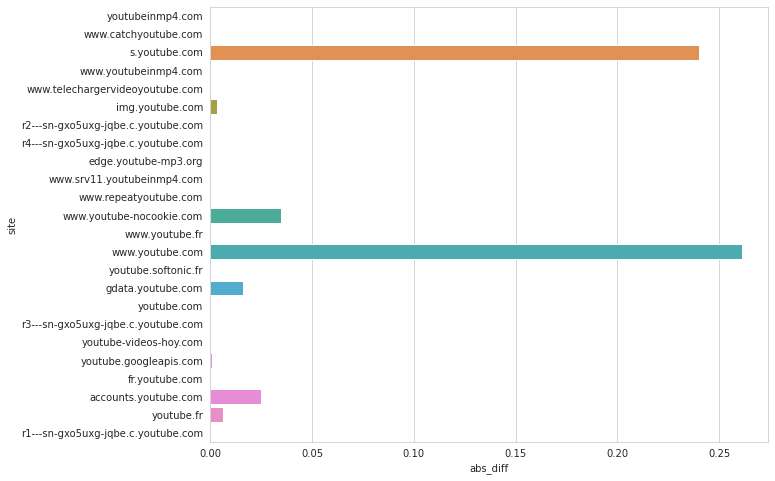

In [ ]:
ytimg = sites_difference(sites, 'youtube')

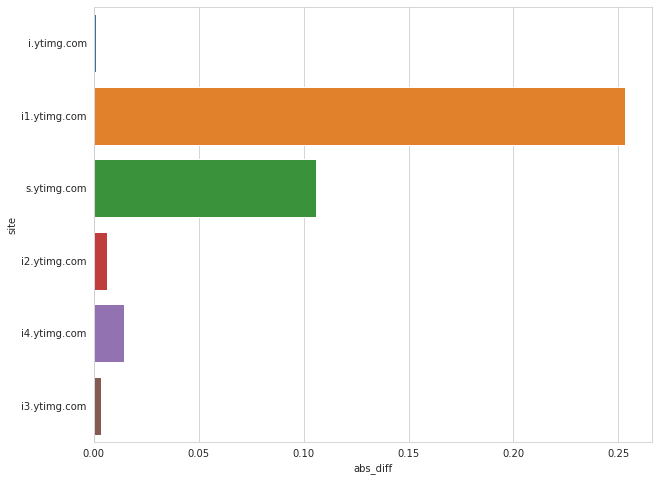

In [ ]:
ytimg = sites_difference(sites, 'ytimg')

## Уникальные сайты

Количество уникальных сайтов в сессии

In [ ]:
unique = nunique(np.array(df_train[['site%s' % i for i in range(1,11)]].fillna(0)), axis=1)

In [ ]:
un = pd.DataFrame({
    'unique': unique,
    'target': df_train.target.values
})

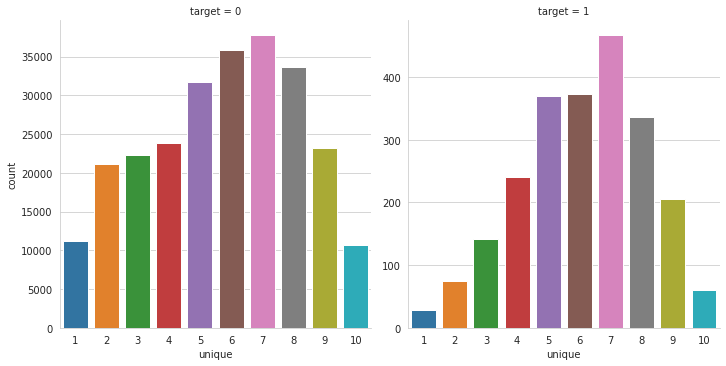

In [ ]:
sns.catplot(x='unique', col='target', data=un, kind='count', sharey=False)

Распределения количества уникальных сайтов для Алисы концентрируется около 7 и ярко выражено.  
Для остальных пользователей это распределение более равномерно.

## Временные периоды

In [ ]:
def time_features(df_train):
  
  df_train['hour']= df_train['time1'].dt.hour
  hour = df_train['time1'].dt.hour

  df_train['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
  df_train['day'] = ((hour >= 12) & (hour <= 18)).astype('int')
  df_train['evening'] = ((hour >= 19) & (hour <= 23)).astype('int')
  df_train['night'] = ((hour >= 0) & (hour <= 6)).astype('int')

  df_train['weekday'] = df_train['time1'].dt.weekday
  df_train['working_day'] = (df_train['weekday']  <= 4).astype('int')

  df_train['month'] = df_train['time1'].dt.month
  df_train['year'] = df_train['time1'].dt.year
  df_train['year_month'] = (100 * df_train['year'] + df_train['month']) / 1e2
  X = df_train
  # session time features
  times = ['time%s' % i for i in range(1, 11)]
  # session duration: take to the power of 1/5 to normalize the distribution
  df_train['session_duration'] = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2
  # number of sites visited in a session
  df_train['number_of_sites'] = X[times].isnull().sum(axis=1).apply(lambda x: 10 - x)
  # average time spent on one site during a session
  df_train['time_per_site'] = (df_train['session_duration'] / df_train['number_of_sites']) ** 0.2

  return df_train

In [ ]:
time = time_features(df_train)
time.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target,hour,morning,day,evening,night,weekday,working_day,month,year,year_month,session_duration,number_of_sites,time_per_site
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,8,1,0,0,0,5,0,1,2013,2013.01,0.000000,2,0.000000
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,8,1,0,0,0,5,0,1,2013,2013.01,17.798209,4,1.347917
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,945.0,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0,8,1,0,0,0,5,0,1,2013,2013.01,5.253056,10,0.879189
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,946.0,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0,8,1,0,0,0,5,0,1,2013,2013.01,4.959344,10,0.869130
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,952.0,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0,8,1,0,0,0,5,0,1,2013,2013.01,4.573051,10,0.855148


Распределение часов, в которые заходила Алиса

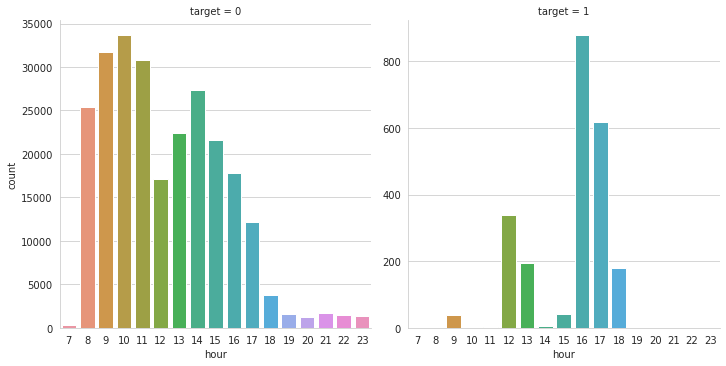

In [ ]:
sns.catplot(x='hour', col='target', data=df_train, kind='count', sharey=False)

У Алисы очень чёткий паттерн использования интернета: подавляющее большинство сессий происходит в следующих промежутках 12-13 часов и 15-18 часов 

Распределение месяцев

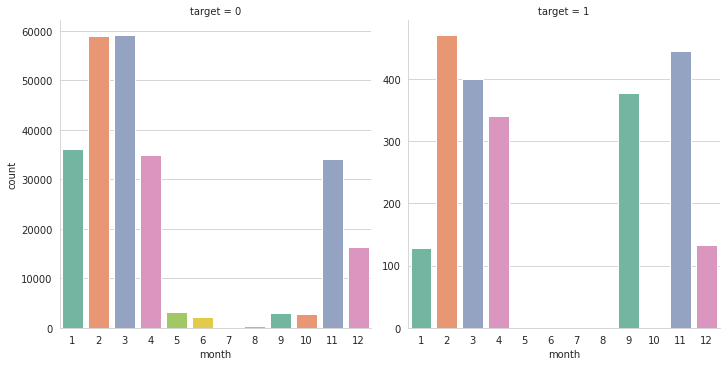

In [ ]:
sns.catplot(x='month', col='target', data=df_train, kind='count', palette='Set2', sharey=False)

Алиса ни разу не заходила с мая по сентябрь, а также в октябре

Распределение дней недели

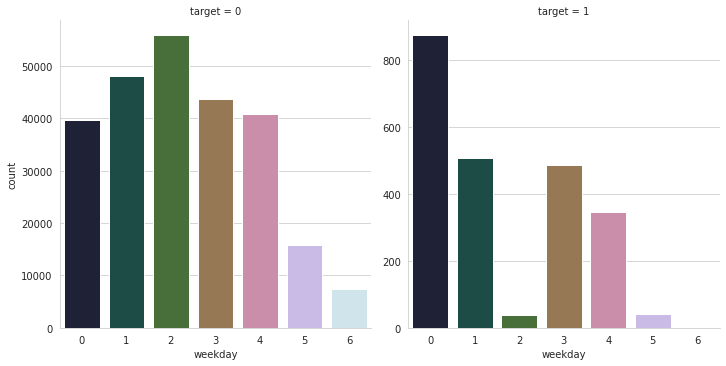

In [ ]:
sns.catplot(x='weekday', col='target', data=df_train, kind='count', palette='cubehelix', sharey=False)

Алиса редко заходит по средам и субботам, а также (почти) никогда - по воскресеньям.

Распределение дат

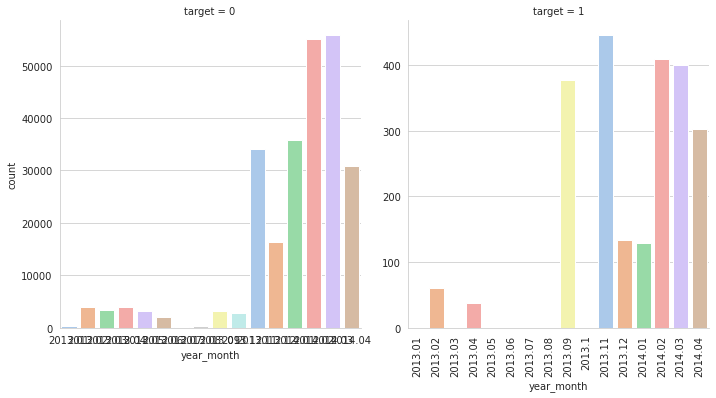

In [ ]:
ax = sns.catplot(x='year_month', col='target', data=df_train, kind='count', sharey=False, palette='pastel')
plt.xticks(rotation=90)
plt.show()

# Preprocessing

In [ ]:
class SitesFeatures(BaseEstimator, TransformerMixin):

  top_alice = np.zeros(10)
  exc_alice = set()

  def fit(self, X, y=None):
    #top_sites
    data = X
    sites = np.array(data[['site%s' % i for i in range(1, 11)]])
    # sites = np.array(data[list(filter(lambda x: 'site' in x, data.columns))])
    sites_alice = np.array(data[list(filter(lambda x: 'site' in x, data.columns))])[data.target == 1].ravel()
    sites_alice = sites_alice[~np.isnan(sites_alice)].astype(int)

    unique = np.unique(sites_alice, return_counts=True)[0]
    freq = np.unique(sites_alice, return_counts=True)[1]
    mask_a = np.argpartition(-freq, 5)[:5]
    self.top_alice = unique[mask_a]

    #exc_sites
    sites_rest = np.array(data[list(filter(lambda x: 'site' in x, data.columns))])[data.target == 0].ravel()
    sites_rest = sites_rest[~np.isnan(sites_rest)].astype(int)
    self.exc_alice = np.array(list(set(sites_alice) - set(sites_rest)))
    return self


  def transform(self, X, y=None):
    data = X
    sites = np.array(data[list(filter(lambda x: 'site' in x, data.columns))])
    
    is_top_alice = np.zeros(sites.shape[0])

    for row in range(sites.shape[0]):
      is_top_alice[row] = np.any(np.isin(sites[row], self.top_alice))

    is_exc_alice = np.zeros(sites.shape[0])

    for row in range(sites.shape[0]):
      is_exc_alice[row] = np.any(np.isin(sites[row], self.exc_alice))

    return np.c_[is_top_alice, 
                 is_exc_alice
                 ]

sites_pipeline = Pipeline([
          ('sites', SitesFeatures())
])

In [8]:
class DataPreparator(BaseEstimator, TransformerMixin):
    """
    Fill NaN with zero values.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        sites = ['site%s' % i for i in range(1, 11)]
        return X[sites].fillna(0).astype('int')

class ListPreparator(BaseEstimator, TransformerMixin):
    """
    Prepare a CountVectorizer friendly 2D-list from data.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.values.tolist()
        # Convert dataframe rows to strings
        return [" ".join([str(site) for site in row]) for row in X]

class AttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new attributes to training and test set.
    """

    def fit(self, X, y=None):
        return self 
      
    def transform(self, X, y=None):
        # intraday features
        hour = X['time1'].apply(lambda ts: ts.hour)
        morning = ((hour >= 7) & (hour <= 11)).astype('int')
        day = ((hour >= 12) & (hour <= 18)).astype('int')
        evening = ((hour >= 19) & (hour <= 23)).astype('int')
        
        # season features
        month = X['time1'].apply(lambda ts: ts.month)
        summer = ((month >= 6) & (month <= 8)).astype('int')
        
        # day of the week features
        weekday = X['time1'].apply(lambda ts: ts.weekday()).astype('int')
        
        # year features
        year = X['time1'].apply(lambda ts: ts.year).astype('int')
        
        #Даты, в которые Алиса активно пользуется интернетом
        active_days = weekday.isin([0,1,3,4])
        active_hours = hour.isin([12,13,15,16,17,18])
        active_months = month.isin([5,9,10,11,12])
        
        #number_of_unique_sites in session
        
        def nunique(a, axis):
          return (np.diff(np.sort(a,axis=axis),axis=axis)!=0).sum(axis=axis)+1


        # unique_sites = pd.get_dummies(nunique(np.array(X[['site%s' % i for i in range(1,11)]].fillna(0)), axis=1) - 1)
        X = np.c_[
                  # morning.values, day.values, evening.values, 
                  # summer.values, 
                  # weekday.values, 
                  # hour.values,
                  active_days.values, active_hours.values,
                  active_months.values,
                  # unique_sites.values
                  ]
        return X

class ScaledAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new features, that should be scaled.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # session time features
        times = ['time%s' % i for i in range(1, 11)]
        # session duration: take to the power of 1/5 to normalize the distribution
        session_duration = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2
        # number of sites visited in a session
        number_of_sites = X[times].isnull().sum(axis=1).apply(lambda x: 10 - x)
        # average time spent on one site during a session
        time_per_site = (session_duration / number_of_sites) ** 0.2
        
        X = np.c_[session_duration.values]
        return X

vectorizer_pipeline = Pipeline([
    ("preparator", DataPreparator()),
    ("list_preparator", ListPreparator()),
    ("vectorizer", 
    #  CountVectorizer(ngram_range=(1, 10), max_features=50000)
     TfidfVectorizer(ngram_range=(1, 10), max_features=100000, sublinear_tf=True)
     )
])

attributes_pipeline = Pipeline([
    ("adder", AttributesAdder())
])

scaled_attributes_pipeline = Pipeline([
    ("adder", ScaledAttributesAdder()),
    ("scaler", StandardScaler())
])

full_pipeline = FeatureUnion(transformer_list=[
  ('vectorizer_pipeline', vectorizer_pipeline),
  ('attributes_pipeline', attributes_pipeline),
  # ('sites_pipeline', sites_pipeline),
  ('scaled_attributes_pipeline', scaled_attributes_pipeline)
], n_jobs=-1)

In [9]:
%time
X_train = full_pipeline.fit_transform(df_train)
X_test = full_pipeline.transform(df_test)

y_train = df_train["target"].astype('int').values

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


# Обучение модели

## Логистическая регрессия

In [ ]:
time_split = TimeSeriesSplit(n_splits=10)

logit = LogisticRegression(C=1, random_state=42, solver='liblinear', n_jobs=-1)
cv_scores = cross_val_score(logit, 
                            X_train,
                            y_train, 
                            cv=time_split, 
                        scoring='roc_auc', n_jobs=-1,
                        verbose=100)

print(cv_scores.mean())
print(cv_scores.std())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:   11.8s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s finished
0.9312245010482035
0.04089270124004518


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
logitcv = LogisticRegressionCV(cv=time_split, scoring='roc_auc', solver='liblinear',  
                               n_jobs=-1, max_iter=100,  verbose=100)
logitcv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  3.8min remaining:   56.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.6min finished
[LibLinear]

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring='roc_auc', solver='liblinear', tol=0.0001,
                     verbose=100)

In [ ]:
logitcv.C_

array([3.70437592])

In [19]:
def write_to_submission(pred, number):
    prediction = pd.DataFrame(pred[:,-1], 
                columns=['target'])
    prediction.index = pd.RangeIndex(1, prediction.shape[0]+1)
    prediction.index.name = 'session_id'
    # return prediction
    prediction.to_csv(f'submission{number}.csv')

In [ ]:
pred = logitcv.predict_proba(X_test)
write_to_submission(pred, 17)
!kaggle competitions submit -c catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2 -f submission17.csv -m "sublinear"

100% 2.19M/2.19M [00:00<00:00, 8.65MB/s]
Successfully submitted to Catch Me If You Can ("Alice")

Результат: 0.96025

## Другие алгоритмы

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
time_split = TimeSeriesSplit(n_splits=10)

sgd = SGDClassifier(loss='log', random_state=42,  n_jobs=-1)
cv_scores = cross_val_score(sgd, 
                            X_train,
                            y_train, 
                            cv=time_split, 
                        scoring='roc_auc', n_jobs=-1,
                        verbose=100)

print(cv_scores.mean())
print(cv_scores.std())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished
0.9206150164654641
0.03734589494589693


In [ ]:
sgd = SGDClassifier(loss='log', random_state=42, n_jobs=-1)
sgd.fit(X_train, y_train,)
pred = sgd.predict_proba(X_test)
write_to_submission(pred, 18)
!kaggle competitions submit -c catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2 -f submission18.csv -m "sgd"

100% 2.12M/2.12M [00:02<00:00, 981kB/s]
Successfully submitted to Catch Me If You Can ("Alice")

Результат - 0.95273

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
sgd = SGDClassifier(random_state=42, n_jobs=-1,  )
params = {
    "loss" : ["log", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1, 1],
    "penalty" : ["l2", "l1", "none"],
}
grid_sgd = GridSearchCV(sgd, params, scoring='roc_auc', n_jobs=-1, cv=time_split, return_train_score=False)
grid_sgd.fit(X_train, y_train)
print(grid_sgd.best_score_, grid_sgd.best_params_)

0.9206150164654641 {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

In [ ]:
svc = LinearSVC(random_state=42)
calib = CalibratedClassifierCV(svc, cv=time_split)
calib.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=42, tol=0.0001,
                                                verbose=0),
                       cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                       method='sigmoid')

In [ ]:
pred = calib.predict_proba(X_test)
write_to_submission(pred, 19)
!kaggle competitions submit -c catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2 -f submission19.csv -m "calib"

100% 2.16M/2.16M [00:03<00:00, 704kB/s]
Successfully submitted to Catch Me If You Can ("Alice")

Результат - 0.95403

# Итог

При построении модели были переброваны:  


*   CountVectorizer и TfidfVectorizer с ngram_range от (1, 2) до (1,10) с различным количеством уникальных признаков
*   Переменные наиболее посещаемых Алисой сайтов и сайтов, посещаемых только ей
*   Различные комбинации переменных часа посещения, дня недели и месяца
*   Переменные длительности сессии, количества уникальных сайтов и среднего времени, проведённого на сайте
*   Такие алгоритмы, как Logistic Regression, LinearSVC, SGDClassifier
*   Такие методы кросс-валидации, как TimeSeriesSplit и StratifiedKFold

